In [331]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [332]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyslim, tskit
import itertools
import scipy.special
import os, subprocess, sys
from Bio import Phylo
from io import StringIO
import msprime
import tqdm
from pathlib import Path
import statsmodels.stats.proportion
import glob
import joblib
import seaborn as sns

sys.path.append(str(Path(os.getcwd()).parent))

In [333]:
from src import extract_tree_stats, curve_inference, estimators, loader, tests

# Test gamma statistic analytically

In [334]:
S = int(1e5)
n = 101

r = scipy.special.binom(np.arange(2, n+1), 2)
coal_times = scipy.stats.expon(scale=1/r).rvs(size=(S, n-1))

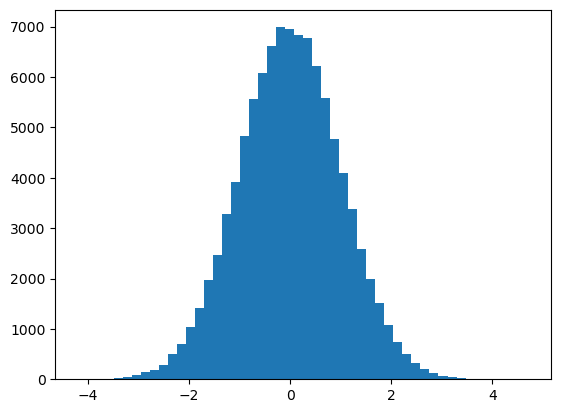

In [179]:
gamma_stats = [tests.gam(C) for C in coal_times]
plt.hist(gamma_stats, bins=50);


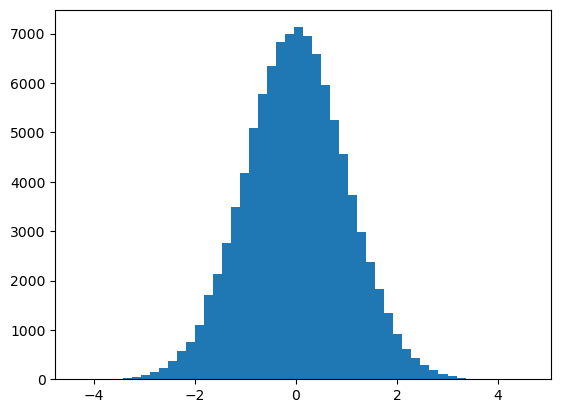

In [182]:
beta_stats = [tests.gam(C, k=10) for C in coal_times]
plt.hist(beta_stats, bins=50);


# Test on one file

In [95]:
logNs = "-3.0"

filenames = glob.glob(
    f"/rds/project/rds-8b3VcZwY7rY/projects/dated_selection/data/paper_simulation_set_20240416/logNs={logNs}/logNUd=2/seed=*/output.trees.tsz"
)

In [99]:
%%time
ts = loader.load_tree_sequence_from_slim(
    filename = filenames[0],
    n_samples_per_time = [100],
    sample_times = [0],
    neutral_mutation_rate_per_genome = 0,
    random_seed = 42,
)

CPU times: user 7.11 s, sys: 1.46 s, total: 8.57 s
Wall time: 8 s


In [100]:
_, tree_coal_times, _, _ = extract_tree_stats.extract_tree_sequence(
    ts,
    sample_times = [0],
    sample_sizes = [100],
    Ne=10000, 
    add_neutral=False,
)

In [108]:
tests.gam(tree_coal_times[::-1])

0.30523757518187405

In [145]:
print("Colless:", ts.first().colless_index())
print("Sackin:", ts.first().sackin_index())
print("B1 index:", ts.first().b1_index())
print("B2 index:", ts.first().b2_index())

Colless: 342
Sackin: 824
B1 index: 52.30955988455991
B2 index: 1.5631364691838892


### Normalized sackin

In [325]:
def sackin_mean(n):
    return 2*(1/np.arange(2,n+1)).sum()

def sackin_var(n):
    return 3 * (n-1)/n  - 4 * (np.arange(2,n+1)**(-2.0)).sum() - 2/n * (1/np.arange(2,n+1)).sum()

In [319]:
print("Norm Sackin:", (ts.first().sackin_index()/100 - sacking_mean(100)) / (sackin_var(100)**0.5))


Norm Sackin: -0.22898561019282304


# Test on multiple files

In [335]:
def runme(filename, n_rep, logNs):
    ts = loader.load_tree_sequence_from_slim(
        filename = filename,
        n_samples_per_time = [100],
        sample_times = [0],
        neutral_mutation_rate_per_genome = 0,
        random_seed = 42,
    )

    _, tree_coal_times, _, _ = extract_tree_stats.extract_tree_sequence(
        ts,
        sample_times = [0],
        sample_sizes = [100],
        Ne=10000, 
        add_neutral=False,
    )

    tree_coal_times = np.concatenate([[0], tree_coal_times])
    tree_coal_diffs = np.diff(tree_coal_times)[::-1]

    stat_gamma = tests.gam(tree_coal_diffs)
    
    stat_beta_5 = tests.gam(tree_coal_diffs, k=5)
    stat_beta_10 = tests.gam(tree_coal_diffs, k=10)
    stat_beta_20 = tests.gam(tree_coal_diffs, k=20)

    try:
        colless = ts.first().colless_index()
    except:
        colless = None

    try:
        sackin = ts.first().sackin_index()
        normalized_sackin = (sackin/100 - sackin_mean(100))/(sackin_var(100)**0.5)
    except:
        sackin = None
        normalized_sackin = None

    try:
        b1 = ts.first().b1_index()
    except:
        b1 = None

    try:
        b2 = ts.first().b2_index()
    except:
        b2 = None
    
    row = [
        logNs, 
        n_rep,
        stat_gamma, 
        stat_beta_5,
        stat_beta_10,
        stat_beta_20,
        colless,
        sackin,
        normalized_sackin,
        b1, 
        b2,
    ]

    return row

rows = joblib.Parallel(n_jobs=40, verbose=10)(
    joblib.delayed(runme)(filename, n_rep, logNs) \
        for logNs in np.arange(-3, 3.75, 0.25) \
        for n_rep, filename in enumerate(glob.glob(
            f"/rds/project/rds-8b3VcZwY7rY/projects/dated_selection/data/paper_simulation_set_20240416/logNs={logNs}/logNUd=2/seed=*/output.trees.tsz"
        ))
)

res_df = pd.DataFrame(rows, columns=["logNs", "n_rep", "gamma", "beta_5", "beta_10", "beta_20", "colless", "sackin", "normalized_sackin", "b1_index", "b2_index"])

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   5 tasks      | elapsed:   18.3s
[Parallel(n_jobs=40)]: Done  18 tasks      | elapsed:   25.7s
[Parallel(n_jobs=40)]: Done  33 tasks      | elapsed:   30.5s
/home/rs2145/rs2145/software/anaconda3/envs/dated_selection/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=40)]: Done  48 tasks      | elapsed:   34.2s
[Parallel(n_jobs=40)]: Done  65 tasks      | elapsed:   39.0s
[Parallel(n_jobs=40)]: Done  82 tasks      | elapsed:   44.4s
[Parallel(n_jobs=40)]: Done 101 tasks      | elapsed:   49.2s
[Parallel(n_jobs=40)]: Done 120 tasks      | elapsed:   53.9s
[Parallel(n_jobs=40)]: Done 141 tasks      | elapsed:   59.9s
[Parallel(n_jobs=40)]: Done 162 tasks      | elapsed:  1.1min
[Paral

### Save to file

In [342]:
res_df.to_csv("../data/varying_logNS.csv", index=False)

### Plot

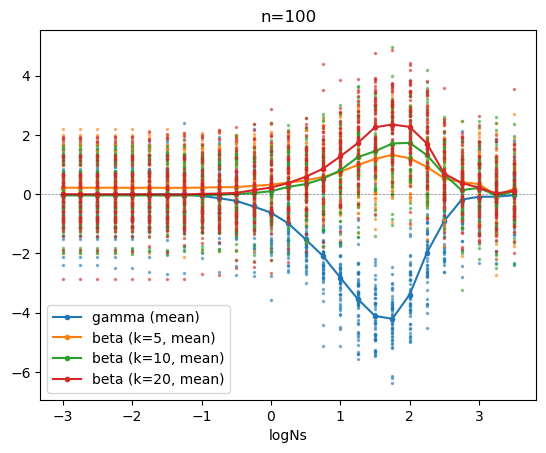

In [336]:
res_means = res_df.groupby(by="logNs").mean().reset_index()

plt.plot(res_means["logNs"], res_means["gamma"], '.-', label="gamma (mean)", color="C0");
plt.plot(res_df["logNs"], res_df["gamma"], '.', color="C0", ms=3, alpha=0.5);

plt.plot(res_means["logNs"], res_means["beta_5"], '.-', label="beta (k=5, mean)", color="C1");
plt.plot(res_df["logNs"], res_df["beta_5"], '.', color="C1", ms=3, alpha=0.5);

plt.plot(res_means["logNs"], res_means["beta_10"], '.-', label="beta (k=10, mean)", color="C2");
plt.plot(res_df["logNs"], res_df["beta_10"], '.', color="C2", ms=3, alpha=0.5);

plt.plot(res_means["logNs"], res_means["beta_20"], '.-', label="beta (k=20, mean)", color="C3");
plt.plot(res_df["logNs"], res_df["beta_20"], '.', color="C3", ms=3, alpha=0.5);

plt.axhline(0, ls="--", lw = 0.5, color="black", alpha=0.5)
plt.xlabel("logNs");
plt.title("n=100");
plt.legend();

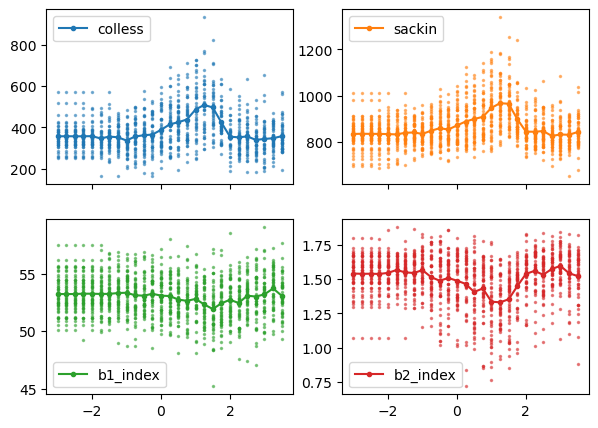

In [337]:
fig, axs = plt.subplots(2, 2, figsize=(7, 5), sharex=True)

for i, (ax, col) in enumerate(zip(axs.ravel(), ["colless", "sackin", "b1_index", "b2_index"])):
    color = "C" + str(i)
    ax.plot(res_means["logNs"], res_means[col], '.-', label=col, color=color);
    ax.plot(res_df["logNs"], res_df[col], '.', color=color, ms=3, alpha=0.5);
    ax.legend()

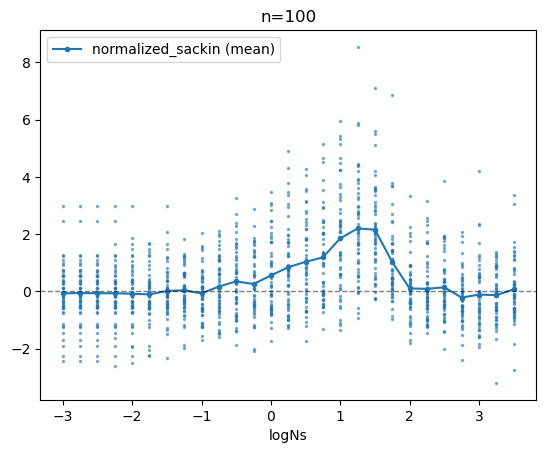

In [338]:
plt.plot(res_means["logNs"], res_means["normalized_sackin"], '.-', label="normalized_sackin (mean)", color="C0");
plt.plot(res_df["logNs"], res_df["normalized_sackin"], '.', color="C0", ms=3, alpha=0.5);

plt.axhline(0, ls="--", lw = 1, color="black", alpha=0.5)
plt.xlabel("logNs");
plt.title("n=100");
plt.legend();

# Convert V, S to $NU_d$, $Ns$

In [176]:
import scipy.optimize

def change_coords(V, S):
    def f(x):
        NUd, Ns = x
        return np.array([NUd * Ns**2 - V, 2 * Ns * np.exp(-NUd / Ns) - S])

    res = scipy.optimize.root(
        fun = f,
        x0 = [0.1, 0.1]
    )

    return res.x[0], res.x[1]
    

In [178]:
NUd, Ns = change_coords(1, 0.01)

V = NUd * Ns**2
S = 2 * Ns * np.exp(-NUd/Ns)

print(NUd, Ns)
print(V, S)

2.8364347202856717 0.5937636457054659
1.0000000000290297 0.009999999989409914


# Plots above but with variable $V$

In [417]:
def runme(filename, n_rep, logV, logS):
    ts = loader.load_tree_sequence_from_slim(
        filename = filename,
        n_samples_per_time = [100],
        sample_times = [0],
        neutral_mutation_rate_per_genome = 0,
        random_seed = 42,
    )

    _, tree_coal_times, _, _ = extract_tree_stats.extract_tree_sequence(
        ts,
        sample_times = [0],
        sample_sizes = [100],
        Ne=10000, 
        add_neutral=False,
    )

    tree_coal_times = np.concatenate([[0], tree_coal_times])
    tree_coal_diffs = np.diff(tree_coal_times)[::-1]

    stat_gamma = tests.gam(tree_coal_diffs)
    
    stat_beta_5 = tests.gam(tree_coal_diffs, k=5)
    stat_beta_10 = tests.gam(tree_coal_diffs, k=10)
    stat_beta_20 = tests.gam(tree_coal_diffs, k=20)

    try:
        colless = ts.first().colless_index()
    except:
        colless = None

    try:
        sackin = ts.first().sackin_index()
        normalized_sackin = (sackin/100 - sackin_mean(100))/(sackin_var(100)**0.5)
    except:
        sackin = None
        normalized_sackin = None

    try:
        b1 = ts.first().b1_index()
    except:
        b1 = None

    try:
        b2 = ts.first().b2_index()
    except:
        b2 = None

    N = 10000
    V = 10**float(logV)
    S = 10**float(logS)

    NUd, Ns = change_coords(V, S)
    Ud = NUd / N
    s = Ns / N
    
    row = [
        logV, 
        logS,
        N,
        Ud, 
        s,
        n_rep,
        stat_gamma, 
        stat_beta_5,
        stat_beta_10,
        stat_beta_20,
        colless,
        sackin,
        normalized_sackin,
        b1, 
        b2,
    ]

    return row

rows = joblib.Parallel(n_jobs=40, verbose=10)(
    joblib.delayed(runme)(filename, n_rep, logV, logS) \
        for logS, logV in (
                list(itertools.product([-2, -1], np.arange(-1, 8.5, 0.5))) + \
                list(itertools.product([0], np.arange(1, 8.5, 0.5))) + \
                list(itertools.product([1], np.arange(2, 8.5, 0.5))) 
            ) \
        for n_rep, filename in enumerate(glob.glob(
            f"/rds/project/rds-8b3VcZwY7rY/projects/dated_selection/data/paper_simulation_set_20240417/logS={logS}/logV={logV}/seed=*/output.trees.tsz",
        ))
)

all_res_V_df = pd.DataFrame(rows, columns=["logV", "logS", "N", "Ud", "s", "n_rep", "gamma", "beta_5", "beta_10", "beta_20", "colless", "sackin", "normalized_sackin", "b1_index", "b2_index"])

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   5 tasks      | elapsed:  1.0min
[Parallel(n_jobs=40)]: Done  18 tasks      | elapsed:  1.4min
[Parallel(n_jobs=40)]: Done  33 tasks      | elapsed:  1.5min
/home/rs2145/rs2145/software/anaconda3/envs/dated_selection/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=40)]: Done  48 tasks      | elapsed:  1.8min
[Parallel(n_jobs=40)]: Done  65 tasks      | elapsed:  2.3min
[Parallel(n_jobs=40)]: Done  82 tasks      | elapsed:  2.6min
[Parallel(n_jobs=40)]: Done 101 tasks      | elapsed:  2.8min
[Parallel(n_jobs=40)]: Done 120 tasks      | elapsed:  2.9min
[Parallel(n_jobs=40)]: Done 141 tasks      | elapsed:  3.0min
[Parallel(n_jobs=40)]: Done 162 tasks      | elapsed:  3.2min
[Paral

In [434]:
all_res_V_df["logS"].unique()

array([-2, -1,  0,  1])

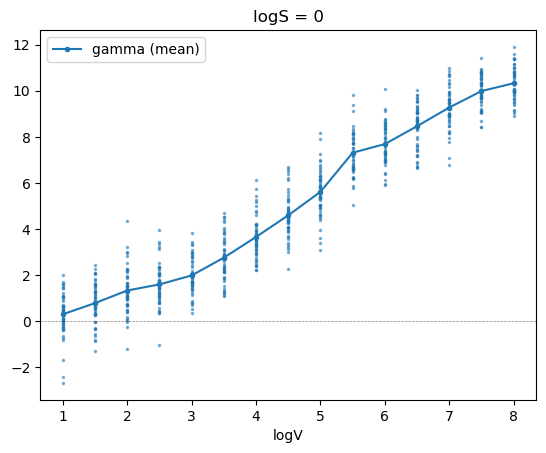

In [436]:
res_V_df = all_res_V_df[all_res_V_df['logS'] == 0]
res_V_means = res_V_df.groupby(by="logV").mean().reset_index()

plt.plot(res_V_means["logV"], -res_V_means["gamma"], '.-', label="gamma (mean)", color="C0");
plt.plot(res_V_df["logV"], -res_V_df["gamma"], '.', color="C0", ms=3, alpha=0.5);

# plt.plot(res_V_means["logV"], res_V_means["beta_5"], '.-', label="beta (k=5, mean)", color="C1");
# plt.plot(res_V_df["logV"], res_V_df["beta_5"], '.', color="C1", ms=3, alpha=0.5);

# plt.plot(res_V_means["logV"], res_V_means["beta_10"], '.-', label="beta (k=10, mean)", color="C2");
# plt.plot(res_V_df["logV"], res_V_df["beta_10"], '.', color="C2", ms=3, alpha=0.5);

# plt.plot(res_V_means["logV"], res_V_means["beta_20"], '.-', label="beta (k=20, mean)", color="C3");
# plt.plot(res_V_df["logV"], res_V_df["beta_20"], '.', color="C3", ms=3, alpha=0.5);

plt.axhline(0, ls="--", lw = 0.5, color="black", alpha=0.5)
plt.xlabel("logV");
plt.title(f"logS = {res_V_df['logS'].iloc[0]}");
plt.legend();

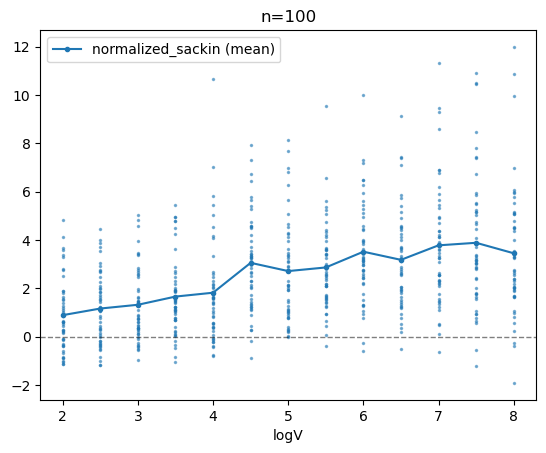

In [430]:
plt.plot(res_V_means["logV"], res_V_means["normalized_sackin"], '.-', label="normalized_sackin (mean)", color="C0");
plt.plot(res_V_df["logV"], res_V_df["normalized_sackin"], '.', color="C0", ms=3, alpha=0.5);

plt.axhline(0, ls="--", lw = 1, color="black", alpha=0.5)
plt.xlabel("logV");
plt.title("n=100");
plt.legend();

In [419]:
all_res_V_df.to_csv("../data/varying_logV.csv", index=False)